In [1]:
import os, sys
import csv
import numpy as np
import pandas as pd

#### 1) Load the data
a) Give the paths to the data folder

b) Load the values of the transverse emittances in lists.

In [2]:
n_sets = 20
n_runs = 3 # number of runs that the simulation was repeated
n_turns = int(1e5)            # number of cycles to run the simulation for
decTurns = int(100)           # how often to record data
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 
separationTime = 1 / f_rev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation

### Iterate over $\alpha_{yy}$

In [3]:
my_start = -2e4 #9.6e3 #400.0
my_stop =  2.01e4 #1.6e4 #1.6e4
my_step = 2000.0

my_variables = list(np.arange(my_start, my_stop, my_step))
#my_variables.insert(0,0.0)
print(my_variables)
print(len(my_variables))

[-20000.0, -18000.0, -16000.0, -14000.0, -12000.0, -10000.0, -8000.0, -6000.0, -4000.0, -2000.0, 0.0, 2000.0, 4000.0, 6000.0, 8000.0, 10000.0, 12000.0, 14000.0, 16000.0, 18000.0, 20000.0]
21


In [4]:
path_to_data = '/afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/'
#study_name = 'sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_Nowakefields_QpxQpy5e-1_ayy'
study_name = 'sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakesON_globalCC_ramp200_QpxQpy1_ayy'
noise_type = 'PN'

### Load the data, and for each Set average over the three runs

Example of study_directory: sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakefieldsON_500slices_QpxQpy2_ayy0.0__fixedKicksSet2_run2


- Set number: corresponds to the different sets of noise kicks
- run number: for each set 3 different runs with different initial distribution.

In [6]:
ex_mean_dict, ey_mean_dict = {}, {} # type: dictionary
ex_std_dict, ey_std_dict = {}, {} # type: dictionary


for var in my_variables: # iterate over ayy
    for my_set in range(n_sets): # iterate over sets
        temp_name = f'{var}_set{my_set}'
        ex_mean, ey_mean = [], []
        for run in range(n_runs): # iterate over runs, compute mean
            try:
                meanX, meanY, meanXsq, meanYsq, emitX, emitY = np.loadtxt(path_to_data+f'{study_name}{var}_fixedKicksSet{my_set}_run{run}/file.txt', delimiter = ",", unpack = True)
                # B1. Create a different list for each run and save the emittance values
                ex_mean.append(emitX)
                ey_mean.append(emitY)
            except OSError as err:
                print("OS error: {0}".format(err))
        ex_mean_dict[temp_name] = np.mean(ex_mean, axis=0) # mean of the 3 runs
        ey_mean_dict[temp_name] = np.mean(ey_mean, axis=0)
        ex_std_dict[temp_name] = np.std(ex_mean, axis=0) # 1 std between the 3 runs
        ey_std_dict[temp_name] = np.std(ey_mean, axis=0)    
        

OS error: /afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakesON_globalCC_ramp200_QpxQpy1_ayy-14000.0_fixedKicksSet8_run0/file.txt not found.
OS error: /afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakesON_globalCC_ramp200_QpxQpy1_ayy10000.0_fixedKicksSet13_run2/file.txt not found.


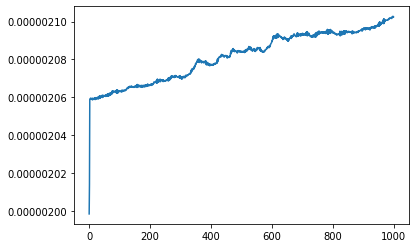

In [10]:
import matplotlib.pyplot as plt
plt.plot(ey_mean_dict[temp_name])

### Do a polynomial fit (deg=1), y-plane only

In [7]:
m_dict = {} # slope of the fit
b_dict = {} # offset
err_dict = {} # error of the gradient of the fit slope

for var in my_variables:
    m_dict[f'{var}'], b_dict[f'{var}'], err_dict[f'{var}'] = [], [], []
    for my_set in range(n_sets):
        temp_name = f'{var}_set{my_set}'
        # linear fit
        [m, b], cov = np.polyfit(tspan[200:], ey_mean_dict[temp_name][200:], 1, cov=True)
        # compute the error of the gradient of the fit slope
        err= np.sqrt(np.diag(cov))
        m_dict[f'{var}'].append(m) # len(m_dict[f'{var}']) = n_runs
        b_dict[f'{var}'].append(b)
        err_dict[f'{var}'].append(err[0])

### Format the computed growth rates in a Data Frame

In [8]:
data = {}
for var in my_variables:
    data[f'ayy_{var}'] =[m_dict[f'{var}'], b_dict[f'{var}'], err_dict[f'{var}']]
df = pd.DataFrame(data, index=['m','b','err'])

filename = f'deyRates_{study_name}Scan.pkl'
if not os.path.exists(filename):
    df.to_pickle(filename)